In [1]:
import sys
sys.path.append("..")

import torch
import matplotlib.pyplot as plt
from dsvit.model import DSViTDetector
from dsvit.dataset import BrainTumorDataset
from dsvit.hooks import register_hooks, INTERMEDIATE_OUTPUTS, ATTENTION_WEIGHTS
from torch.utils.data import Subset
import numpy as np
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DSViTDetector()
model.load_state_dict(torch.load("/Users/darshdave/Documents/BRAINTUMOR/DSVIT/model-weight/best_dsvit_detector.pth"))
model.eval()
model = model.to(device)

hook_handles = register_hooks(model)

In [3]:
dataset = BrainTumorDataset("/Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/")
sample_loader = torch.utils.data.DataLoader(Subset(dataset, [0]), batch_size=1)

sample_img, _ = next(iter(sample_loader))
sample_img = sample_img.to(device)

In [4]:
with torch.no_grad():
    _ = model(sample_img)

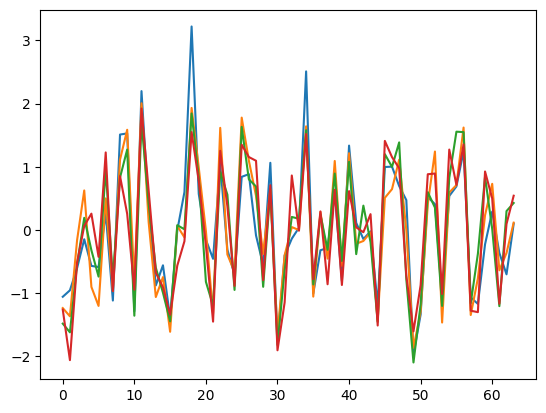

In [5]:
for name, token_output in INTERMEDIATE_OUTPUTS.items():
    token_0 = token_output[0, 0].cpu().numpy()
    plt.plot(token_0, label=name)

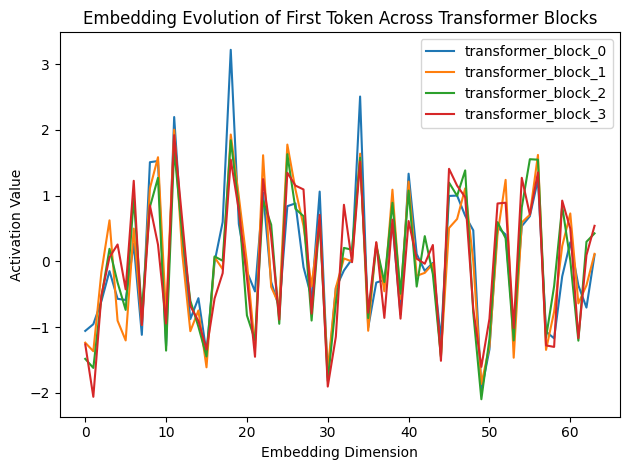

In [6]:
for name, token_output in INTERMEDIATE_OUTPUTS.items():
    # token_output shape: (B, N, D) — visualize token 0 (e.g., global token)
    token_0 = token_output[0, 0].cpu().numpy()
    plt.plot(token_0, label=name)

plt.title("Embedding Evolution of First Token Across Transformer Blocks")
plt.xlabel("Embedding Dimension")
plt.ylabel("Activation Value")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
for h in hook_handles:
    h.remove()

In [8]:
def visualize_tokens_as_grid(tensor, grid_shape=(8, 8), title=None):
    fig, axes = plt.subplots(*grid_shape, figsize=(10, 10))
    tensor = tensor.reshape(*grid_shape, -1)  # (8,8,D)

    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            ax = axes[i, j]
            patch = tensor[i, j]
            ax.imshow(patch.reshape(1, -1), cmap='viridis', aspect='auto')
            ax.axis('off')

    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

/var/folders/tg/8krns30j2ts1jmdqxg4zzlwm0000gn/T/ipykernel_77531/1024611372.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


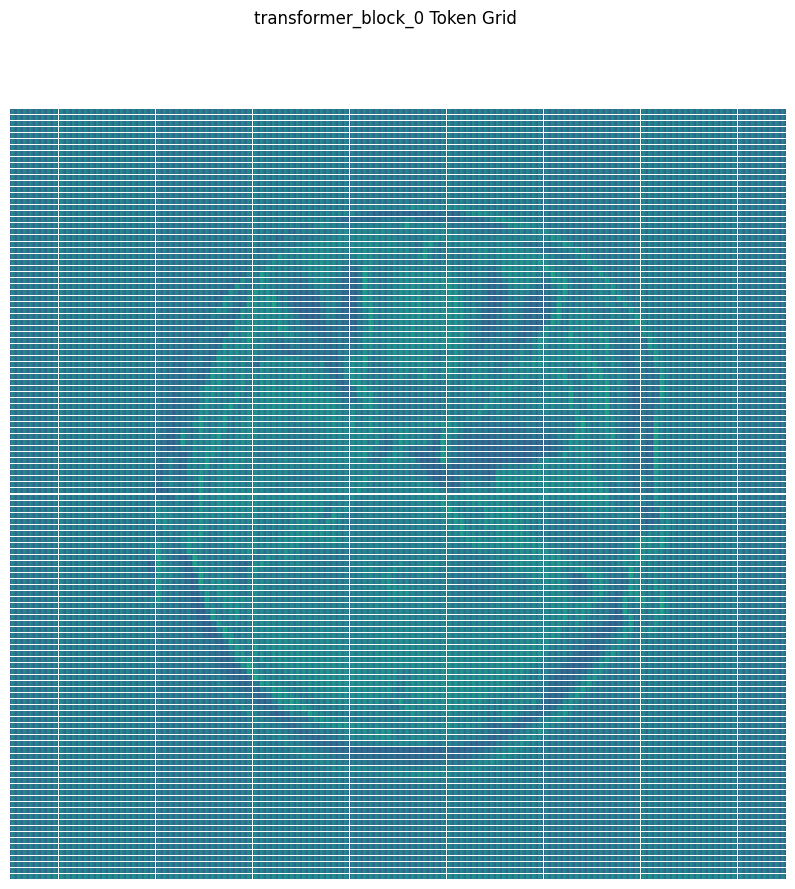

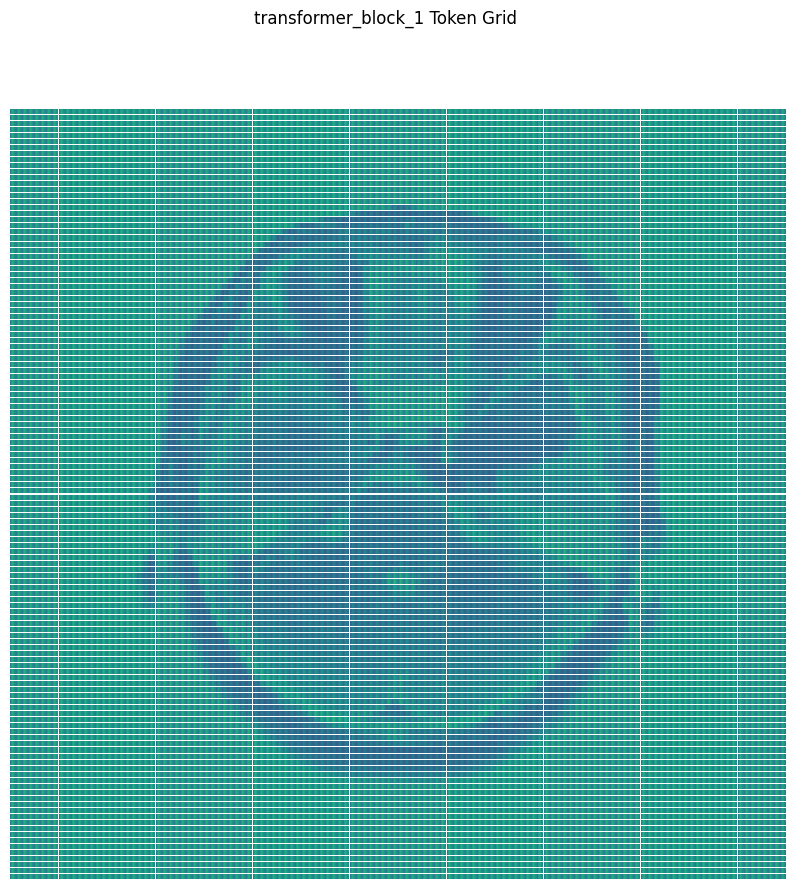

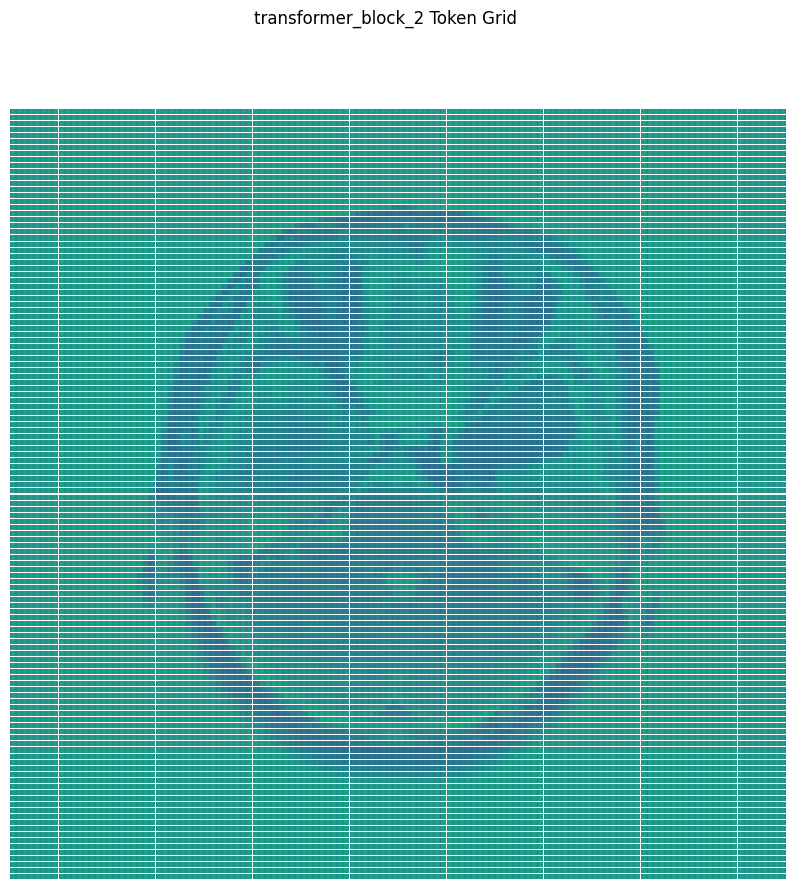

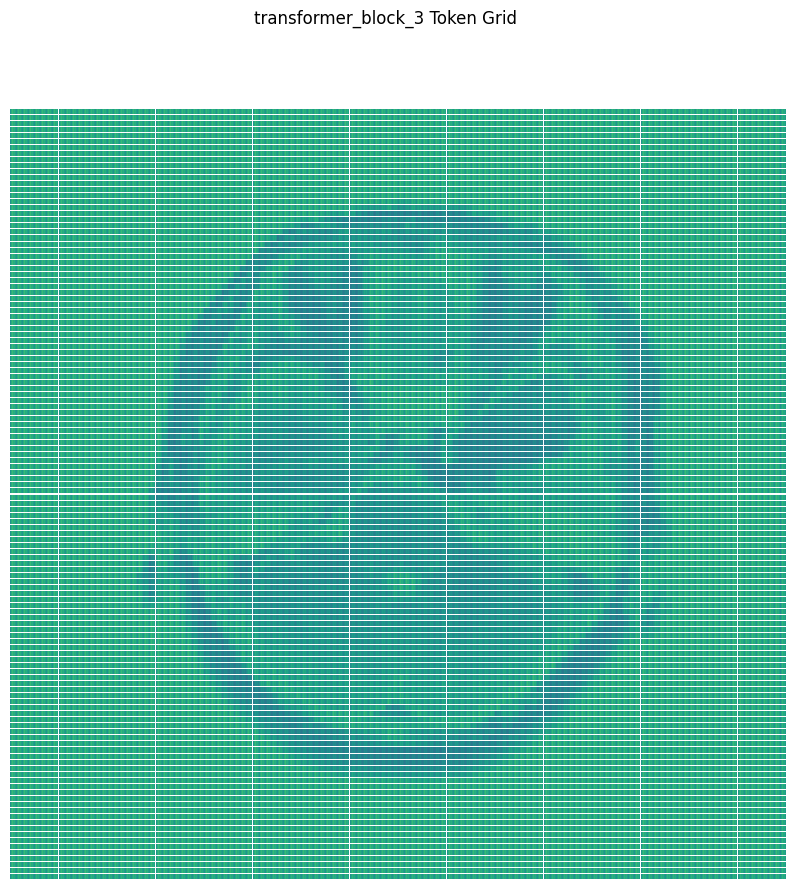

In [12]:
# Visualize all token embeddings from each block
for name, token_output in INTERMEDIATE_OUTPUTS.items():
    # Shape: (B, N, D) — use first image
    tokens = token_output[0]  # (N, D)

    N, D = tokens.shape
    grid_dim = int(math.sqrt(N))  # e.g., if N=64 → 8x8

    if grid_dim * grid_dim != N:
        print(f"Skipping {name}: token count {N} not a perfect square")
        continue

    # Normalize and reshape
    norm_tokens = (tokens - tokens.min()) / (tokens.max() - tokens.min() + 1e-5)
    tokens_img = norm_tokens.view(grid_dim, grid_dim, D)

    visualize_tokens_as_grid(tokens_img, (grid_dim, grid_dim), title=f"{name} Token Grid")


In [11]:
def plot_attention_map(attn, title="Attention Map", token_idx=0):
    """
    Visualizes attention from one token to all others, reshaped as grid.
    Works for attn shape: (1, heads, N, N) or (1, N, N)
    """
    attn = attn[0]  # remove batch
    print(f"[DEBUG] Attention shape: {attn.shape}")

    if attn.ndim == 2:
        # Shape: (N, N) → single-head attention
        attn = attn[token_idx]
        grid_size = int(np.sqrt(attn.shape[0]))
        attn_img = attn.cpu().numpy().reshape(grid_size, grid_size)
        
        plt.figure(figsize=(4, 4))
        plt.imshow(attn_img, cmap='plasma')
        plt.title(f"{title} (Single Head)")
        plt.axis('off')
        plt.show()

    elif attn.ndim == 3:
        # Shape: (heads, N, N)
        num_heads, N, _ = attn.shape
        grid_size = int(np.sqrt(N))

        fig, axes = plt.subplots(1, num_heads, figsize=(15, 4))
        for i in range(num_heads):
            ax = axes[i]
            attn_map = attn[i][token_idx].cpu().numpy().reshape(grid_size, grid_size)
            ax.imshow(attn_map, cmap='plasma')
            ax.set_title(f"Head {i+1}")
            ax.axis('off')

        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    else:
        print("❌ Unexpected attention shape:", attn.shape)


[DEBUG] Attention shape: torch.Size([16384, 16384])


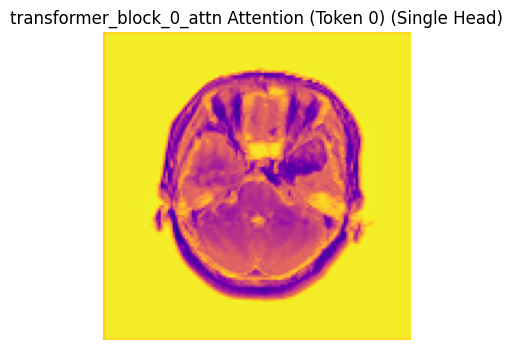

[DEBUG] Attention shape: torch.Size([16384, 16384])


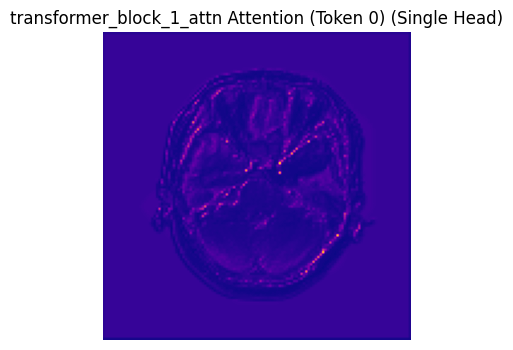

[DEBUG] Attention shape: torch.Size([16384, 16384])


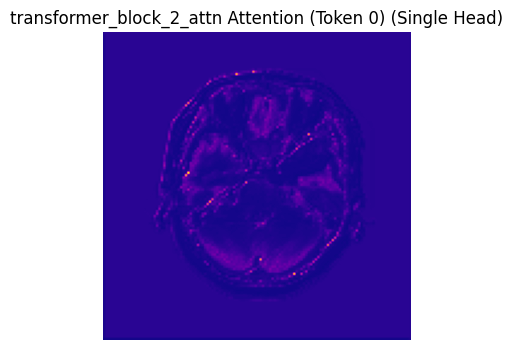

[DEBUG] Attention shape: torch.Size([16384, 16384])


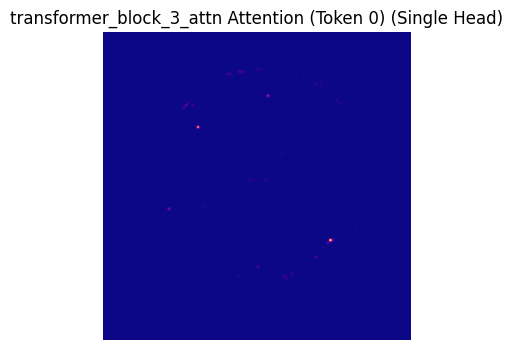

In [12]:
for name, attn in ATTENTION_WEIGHTS.items():
    plot_attention_map(attn, title=f"{name} Attention (Token 0)", token_idx=0)